Importing library and dataframe

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

df=pd.read_csv("Daily.csv")
df

,Date,Price,Open,High,Low,Vol.,Change %
0,15-09-2024,"2,402.04","2,417.56","2,428.91","2,396.68",133.42K,-0.64%
1,14-09-2024,"2,417.56","2,439.29","2,440.40","2,384.99",154.06K,-0.92%
2,13-09-2024,"2,440.12","2,361.79","2,459.47","2,337.76",302.56K,3.32%
3,12-09-2024,"2,361.79","2,340.33","2,387.25","2,316.39",249.29K,0.92%
4,11-09-2024,"2,340.19","2,387.98","2,388.40","2,279.00",333.29K,-1.99%
...,...,...,...,...,...,...,...
3107,14-03-2016,12.50,15.07,15.07,11.40,92.18K,-17.05%
3108,13-03-2016,15.07,12.92,15.07,12.92,1.30K,16.64%
3109,12-03-2016,12.92,11.95,13.45,11.95,0.83K,8.12%
3110,11-03-2016,11.95,11.75,11.95,11.75,0.18K,1.70%


## Data preprocessing

In [2]:
# dropping irrelevant data for regression
def drop_irrelevant(df):
    df=df.drop(["Open","High","Low","Vol.","Change %"],axis=1)
    return df
df = drop_irrelevant(df)

In [3]:
# checking for null values
print(df.isnull().sum())

Date     0
Price    0
dtype: int64


In [4]:
# conversion of date and price to specific datatype
def pre_processing(df):
    # price pre-processing
    for i in range(len(df)):
        if "," in df.loc[i,"Price"]:
            val=df.loc[i,"Price"]
            df.loc[i,"Price"]=float(val[:val.find(",")]+val[val.find(",")+1:])
        else:
            df.loc[i,"Price"]=float(df.loc[i,"Price"])

    # date pre-processing
    from datetime import datetime
    df["Date"]=pd.to_datetime(df["Date"] , format="%d-%m-%Y")

    df=df.sort_values(by="Date")
    return df

df = pre_processing(df)

In [5]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import HoverTool
from bokeh.io import push_notebook

# plts the preprocessed dataset
def plot_dataset(df): 
    output_notebook() 


    p = figure(width=1150, height=600, x_axis_type='datetime', title='Interactive Date vs Price Plot',
        background_fill_color="#2F2F2F",  # Dark background
        border_fill_color="#2F2F2F",  # Dark border
        outline_line_color="#FFFFFF"  # Light border)
    )

    # Add a line renderer
    p.line(df['Date'], df['Price'], line_width=2, color='blue', legend_label='Price')

    # Add hover tool
    hover = HoverTool()
    hover.tooltips = [("Date", "@x{%F}"), ("Price", "@y")]
    hover.formatters = {'@x': 'datetime'}
    p.add_tools(hover)

    # Customize axes
    p.xaxis.axis_label = 'Date'
    p.yaxis.axis_label = 'Price ($)'

    # Show the plot
    show(p, notebook_handle=True)

In [6]:
plot_dataset(df)

Loading BokehJS ...

Converting categorical data to numerical data

In [7]:
# converting date to numerical value for regression task
def encode(df):
    from sklearn.preprocessing import LabelEncoder

    df["Date"]=df["Date"].astype(str)

    le=LabelEncoder()

    unique_values=df["Date"].unique()

    le.fit(unique_values)
    df["Date"]=le.transform(df["Date"])

    return df

df = encode(df)
df


,Date,Price
3111,0,11.75
3110,1,11.95
3109,2,12.92
3108,3,15.07
3107,4,12.5
...,...,...
4,3107,2340.19
3,3108,2361.79
2,3109,2440.12
1,3110,2417.56


In [8]:
df.drop(['Date'], axis= 1, inplace=True)

In [9]:
df.head()

# converts a 1D dataset into 2D dataset with lags for each datapoint
def make_dependence_dataset(df, x_shift, target_shift = 1):
    new_df = pd.DataFrame()
    if x_shift > df.shape[0]:
        return new_df

    # x_shift the dataset by i points hence we got our Lag (x_shift - i)
    total = x_shift + target_shift
    for i in range(total , target_shift, -1):
        new_df[f'Lag_{total - i + 1 }'] = df.shift(i)
    for i in range( target_shift , 0 , -1 ):
        new_df[f'target_{target_shift - i}'] = df.shift(i)
    new_df.dropna(inplace=True)
        
    return new_df


In [10]:
def full_preprocessing(df, drop_irrelevant_data= True, pre_process = True, drop_date= False ,to_encode= True):
    if drop_irrelevant_data:
        df = drop_irrelevant(df)
    if pre_process:
        df = pre_processing(df)
    if to_encode:
        df = encode(df)
    if drop_date:
        df.drop(['Date'], axis= 1, inplace=True)
    
    df.reindex()
    return df

## Ridge Regression

In [11]:
def get_featues_target(df, x_shift, target_shift):
    lagged_dataset = make_dependence_dataset(df,x_shift, target_shift)
    features = lagged_dataset.drop([f"target_{i}" for i in range(target_shift)], axis = 1)
    target = lagged_dataset[[f"target_{i}" for i in range(target_shift)]]
    return features, target
make_dependence_dataset(df, 10)

,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,target_0
3100,11.75,11.95,12.92,15.07,12.5,13.06,12.88,10.74,10.74,10.31,10.18
3099,11.95,12.92,15.07,12.5,13.06,12.88,10.74,10.74,10.31,10.18,11.95
3098,12.92,15.07,12.5,13.06,12.88,10.74,10.74,10.31,10.18,11.95,11.37
3097,15.07,12.5,13.06,12.88,10.74,10.74,10.31,10.18,11.95,11.37,12.43
3096,12.5,13.06,12.88,10.74,10.74,10.31,10.18,11.95,11.37,12.43,11.2
...,...,...,...,...,...,...,...,...,...,...,...
4,2513.56,2427.49,2538.35,2423.4,2450.18,2369.18,2225.72,2274.87,2296.19,2359.6,2387.71
3,2427.49,2538.35,2423.4,2450.18,2369.18,2225.72,2274.87,2296.19,2359.6,2387.71,2340.19
2,2538.35,2423.4,2450.18,2369.18,2225.72,2274.87,2296.19,2359.6,2387.71,2340.19,2361.79
1,2423.4,2450.18,2369.18,2225.72,2274.87,2296.19,2359.6,2387.71,2340.19,2361.79,2440.12


In [12]:
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import root_mean_squared_error,mean_absolute_percentage_error


shifts = [i for i in range(1, 12, 5)]
y_shifts = [i for i in range(1, 5, 1)] ## how much in future to predict i.e. 1 day, 2days, 3 days, etc
cvs = [i for i in range(2, 10)]
polys = [i for i in range(1, 4)]

df = pd.read_csv("train.csv")
df = full_preprocessing(df, drop_date=True)

test_df = pd.read_csv('test.csv')
test_df = full_preprocessing(test_df, drop_date= True)

result = []

for shift in shifts:
    for y_shift in y_shifts:
        print(f"\nShift {shift}, {y_shift}")
        X_train, y_train = get_featues_target(df, shift,y_shift)
        X_test, y_test = get_featues_target(test_df, shift, y_shift)

        # Apply StandardScaler
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        for poly in polys:
            poly_transformer = PolynomialFeatures(degree=poly)
            poly_X_train = poly_transformer.fit_transform(X_train)
            poly_X_test = poly_transformer.fit_transform(X_test)
            for cv in cvs:
                rd_model = RidgeCV(alphas=np.logspace(-6, 6, 13),cv=cv)
                rd_model.fit(poly_X_train, y_train)
                y_pred = rd_model.predict(poly_X_test)
                result.append([shift, y_shift, poly, cv, -root_mean_squared_error(y_test, y_pred)]) ## sorting on rms value the one with least rms on test data is choosen best
                
            print(f"Poly {poly}",end="\t")

result = np.array(result)

        


Shift 1, 1
Poly 1	Poly 2	Poly 3	
Shift 1, 2
Poly 1	Poly 2	Poly 3	
Shift 1, 3
Poly 1	Poly 2	Poly 3	
Shift 1, 4
Poly 1	Poly 2	Poly 3	
Shift 6, 1
Poly 1	Poly 2	Poly 3	
Shift 6, 2
Poly 1	Poly 2	Poly 3	
Shift 6, 3
Poly 1	Poly 2	Poly 3	
Shift 6, 4
Poly 1	Poly 2	Poly 3	
Shift 11, 1
Poly 1	Poly 2	Poly 3	
Shift 11, 2
Poly 1	Poly 2	Poly 3	
Shift 11, 3
Poly 1	Poly 2	Poly 3	
Shift 11, 4
Poly 1	Poly 2	Poly 3	

In [ ]:
sorted_ind = result[:,-1].argsort()
result = result[sorted_ind] 

In [14]:
import warnings

# Suppress RuntimeWarnings, which includes LinAlgWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)

## getting the best values of shift, cv, and polynomial
best_shift, best_y_shift ,best_poly , best_cv , _ = result[-1]
best_shift = (int)(best_shift); best_cv = (int)(best_cv); best_poly = (int)(best_poly);  best_y_shift = (int)(best_y_shift)
poly_transformer = PolynomialFeatures(degree=best_poly) 
print(best_shift, best_y_shift, best_poly, best_cv)

## training the best model
best_rd_model = RidgeCV(cv=best_cv)
X_train, y_train = get_featues_target(df, best_shift,best_y_shift)
X_test, y_test = get_featues_target(test_df, best_shift,best_y_shift)

poly_X_train = poly_transformer.fit_transform(X_train)
poly_X_test = poly_transformer.fit_transform(X_test)
best_rd_model.fit(poly_X_train,y_train)

## prediction and scores
y_pred = best_rd_model.predict(poly_X_test)
print("Root mean Squared Error", root_mean_squared_error(y_test, y_pred))
print("Mean Absolute Percentage Error", mean_absolute_percentage_error(y_test, y_pred))
print("Model score",best_rd_model.score(poly_X_test, y_test))

6 1 3 3
Root mean Squared Error 102.06293459158348
Mean Absolute Percentage Error 0.02426772879875689
Model score 0.9575359648887618


In [15]:
def plot_ridge_comparison(y_true,y_pred, title='Interactive Date vs Price Plot'):
    if y_true.shape[0] != y_pred.shape[0]:
        print(f"incompactible {y_true.shape} {y_pred.shape}")
        return
    output_notebook() 
    x_data = [i for i in range(y_true.shape[0])]

    p = figure(width=1150, height=600,  title=title,
        background_fill_color="#424242",  # Dark background
        border_fill_color="#2F2F2F",  # Dark border
        outline_line_color="#FFFFFF"  # Light border
    )

    # Add a line renderer
    p.line(x_data, y_true, line_width=2, color='#F57F17', legend_label='True')
    p.line(x_data, y_pred, line_width=2, color='#AB47BC', legend_label='Predicted')

    # Add hover tool
    hover = HoverTool()
    p.add_tools(hover)

    # Customize axes
    p.xaxis.axis_label = 'Date'
    p.yaxis.axis_label = 'Price ($)'

    # Show the plot
    show(p, notebook_handle=True)

### Testing

back_pred is on training dataset 
front_pred is on test dataset

In [16]:
model_back_pred = best_rd_model.predict(poly_X_train)
model_front_pred = best_rd_model.predict(poly_X_test)

plot_ridge_comparison(y_train.iloc[:,0], model_back_pred[:,0], 'Interactive Date vs Price Plot for TRAINING DATA')
plot_ridge_comparison(y_test.iloc[:,0], model_front_pred[:,0], 'Interactive Date vs Price Plot for TEST DATA')

Loading BokehJS ...

Loading BokehJS ...

### Inference

Ridge Regression performs well in preddicting whether the values will go 'RISE' or 'FALL'. It has very good bais as well as variance.

We did not tested the model on the predicted values of the model itself, because the model was not able to perform good at it. This model mainly predict the next day value and then waits for the next actual data to arrive in order to predict the next and so on.

# AUTO

## Data preprocessing

In [17]:
df=pd.read_csv("Daily.csv")
df

,Date,Price,Open,High,Low,Vol.,Change %
0,15-09-2024,"2,402.04","2,417.56","2,428.91","2,396.68",133.42K,-0.64%
1,14-09-2024,"2,417.56","2,439.29","2,440.40","2,384.99",154.06K,-0.92%
2,13-09-2024,"2,440.12","2,361.79","2,459.47","2,337.76",302.56K,3.32%
3,12-09-2024,"2,361.79","2,340.33","2,387.25","2,316.39",249.29K,0.92%
4,11-09-2024,"2,340.19","2,387.98","2,388.40","2,279.00",333.29K,-1.99%
...,...,...,...,...,...,...,...
3107,14-03-2016,12.50,15.07,15.07,11.40,92.18K,-17.05%
3108,13-03-2016,15.07,12.92,15.07,12.92,1.30K,16.64%
3109,12-03-2016,12.92,11.95,13.45,11.95,0.83K,8.12%
3110,11-03-2016,11.95,11.75,11.95,11.75,0.18K,1.70%


In [18]:
df = full_preprocessing(df, to_encode=False)

## Auto Regression

Finding auto_correlation to get number of Lag features

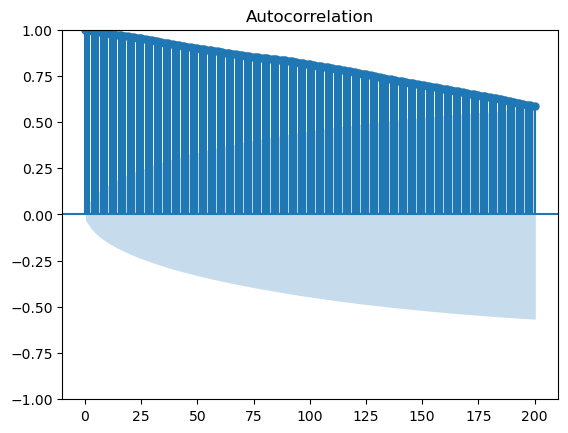

In [19]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
series=df["Price"]
plot_acf(series,lags=200)
plt.show()

Thus 200 Lag features are sufficient for us

Creating Lag features and dropping rows with NULL values

In [20]:
# Creating a true copy
df_v=df.copy()

# Inserting Lag features into the copy 
df_v_price = make_dependence_dataset(df_v['Price'], 200)

## changing column names as required by AUTO
df_v_price['Date'] = df_v['Date']
df_v_price.rename(columns= {'target_0':'Price'}, inplace=True)
df_v = df_v_price

# Split the data into training and testing sets
# such that first 80% of data is train and
# rest 20% is test
train_size = int(0.8 * len(df_v))
train_data = df_v[:train_size]
test_data = df_v[train_size:]
 
# Define the input features (lag features) and target variable
y_train = train_data["Price"]
y_test = test_data["Price"]

Training the model with Training data

In [21]:
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import AutoReg
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error

# Fitting with 200 Lag features as chosen above
ar_model=AutoReg(np.array(y_train),lags=200)
ar_results=ar_model.fit()

Predicting on test set and finding MAE,MSE,MAPE

In [22]:
# Make predictions on the test set
y_pred = ar_results.predict(start=len(train_data),end=len(train_data)+len(test_data)-1, dynamic=False)
 
# Calculate MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape=mean_absolute_percentage_error(y_test,y_pred)
print("Mean Absolute Error:",mae)
print("Root Mean Squared Error:",rmse)
print("Mean Absolute Percentage Error:",mape)

Mean Absolute Error: 1159.2084148463607
Root Mean Squared Error: 1401.1453459692893
Mean Absolute Percentage Error: 0.43556616268146797


Plotting and Comparing Predicted values with Real data

In [23]:
output_notebook() 

p = figure(width=1150, height=600, x_axis_type='datetime', title='Interactive Date vs Price Plot for test Data (AUTO)',
    background_fill_color="#2F2F2F",  # Dark background
    border_fill_color="#2F2F2F",  # Dark border
    outline_line_color="#FFFFFF"  # Light border)
)

# Add a line renderer
p.line(test_data["Date"],test_data["Price"], line_width=2, color="blue", legend_label="True Price")
p.line(test_data["Date"],y_pred,line_width=2,color="red",legend_label="Predicted Price")

# Add hover tool
hover = HoverTool()
hover.tooltips = [("Date", "@x{%F}"), ("Price", "@y")]
hover.formatters = {'@x': 'datetime'}
p.add_tools(hover)

# Customize axes
p.xaxis.axis_label = "Date"
p.yaxis.axis_label = "Price ($)"

# Show the plot
show(p, notebook_handle=True)


Loading BokehJS ...

# ARIMA Model

Extracting Lag features and Price to pass to ARIMA Model for both train and test

In [24]:
from statsmodels.tsa.arima.model import ARIMA

x_train = train_data[[f'Lag_{i}' for i in range(1, 201)]]
x_train=np.array(x_train,dtype="float64")

x_test=test_data[[f'Lag_{i}' for i in range(1, 201)]]
x_test=np.array(x_test,dtype="float64")

y_train = np.array(train_data["Price"],dtype="float64")


Training the model on the given Lag features and Price

In [25]:
arima_model = ARIMA(y_train, order=(0, 0, 1),exog=x_train)
arima_result=arima_model.fit()

Predicting on Test data by passing Lag features

In [26]:
y_pred=arima_result.forecast(steps=len(test_data),exog=x_test)

Computing MSE,MAE,MAPE

In [27]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape=mean_absolute_percentage_error(y_test,y_pred)
print("Mean Absolute Error:",mae)
print("Root Mean Squared Error:",rmse)
print("Mean Absolute Percentage Error:",mape)

Mean Absolute Error: 57.070324456634154
Root Mean Squared Error: 84.01259879455787
Mean Absolute Percentage Error: 0.02358470488108495


Plotting and Comparing Predicted values with Real data

In [28]:
output_notebook() 

p = figure(width=1150, height=600, x_axis_type='datetime', title='Interactive Date vs Price Plot for test data (ARIMA)',
    background_fill_color="#2F2F2F",  # Dark background
    border_fill_color="#2F2F2F",  # Dark border
    outline_line_color="#FFFFFF"  # Light border)
)

# Add a line renderer
p.line(test_data["Date"],y_test, line_width=2, color="blue", legend_label="True Price")
p.line(test_data["Date"],y_pred,line_width=2,color="red",legend_label="Predicted Price")

# Add hover tool
hover = HoverTool()
hover.tooltips = [("Date", "@x{%F}"), ("Price", "@y")]
hover.formatters = {'@x': 'datetime'}
p.add_tools(hover)

# Customize axes
p.xaxis.axis_label = "Date"
p.yaxis.axis_label = "Price ($)"

# Show the plot
show(p, notebook_handle=True)

Loading BokehJS ...